<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2019


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> Motion correction </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> September 23, 2019 </b></p>

<hr style='height:5px;border:none' />

# Overview of pre-processing steps
<hr style="height:1px;border:none" />

<img style='width: 600px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Nipype_fMRIOverview.png?raw=true' alt='fMRI data analysis flow'/>

Starting today, we will learn how to pre-process an fMRI data set so that it will be ready to be analyzed. There are several steps in fMRI pre-processing, and different software tools implement different steps at different stages of preprocessing. Here, my goal is to show some essential steps in pre-processing; whey these steps are needed, and how they can be implemented.

Here are steps of fMRI pre-processing. The order may vary in different software packages, but the idea behind these steps is the same. 

  1. **Slice timing correction**: Corrects for the time differences slice acquisition
  2. **Motion correction / realignment**: Corrects for any spatial displacement during fMRI acquisition
  3. **Artifact detection**: Corrects for any physiological artifacts during acquisition
  4. **Co-registration**: Re-orients the image in the same space as the T1-weighted image
  5. **Normalization**: Applies the warping from T1-image normalization to transform fMRI data into the template space
  6. **Spatial smoothing**: Smooth fMRI data with a Gaussian kernel
  7. **Applying a brain mask**: Apply a brain mask so that only the brain voxels are used in the data analysis.
  
Today, we shall cover motion correction. We will cover co-registration, normalization, and spatial smoothing in the next class.

# Brief introduction to Nipype
<hr style="height:1px;border:none" />

## Steps in fMRI data analysis

Although there are different software tools designed for fMRI data analysis, the steps required for such an analysis is very similar for the most part. 

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Nipype_NeuroImageSchematic.png?raw=true' alt='fMRI processing steps'/>

Different software packages implements these steps to analyze fMRI data. So, in theory, it is possible to mix different steps from different software tools but you can still implement all the necessary steps.

In recent years, it is becoming increasing common to run a pipeline script (e.g., *fMRIprep*) combining various functionalities from different software tools (e.g., normalization from ANTS, artifact detection from AFNI, smoothing from SPM, etc). Perhaps your lab may have a preprocessing script written by your predecessor. Running each of the pre-processing steps individually is somewhat unusual today. However, for your didactic purposes, I shall go over each step separately today and next class. I use FSL for the sake of simplicity, but by no means it is the best tool for all steps. 


## Why nipype?

Different fMRI analysis software tools have their own scripting capability. In other words, each package lets you write a script (a series of instructions) to implement the entire analysis pipeline from the beginning to the end. This is useful especially you have to run the same pre-processing and analysis steps for multiple subjects. Analyzing multiple subjects' data using a GUI will increase the risk of human error (clicking a wrong button, selecting a wrong file, entering wrong parameters, etc.). 

The syntax to script a processing pipeline is different in different packages. For a starter, in SPM you write a script in MATLAB, whereas in FSL, you need to code in a shell script. **Nipype** enables you to script different steps in different software tools in Python, so that mixing of different steps very easy.

<img style='width: 650px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2018/blob/master/Images/Nipype_WorkflowEg.png?raw=true' alt='Nipype workflow example'/>

Here is an example of how `nipype` implements different steps. The diagram such as this one represents a **workflow**, a series of tasks organized into a diagram, with output from one task fed into the following task. Here, each task is represented as a **node**. A node may take a certain input(s) and produces an output. 

# What is motion correction?
<hr style="height:1px;border:none" />

Even if you instruct a subject not to move during an fMRI experiment, chances are, he / she is unable to hold absolutely still. In other words, he or she does move the head. So why does it matter if the subject moves the head? That is because signals may not align across time points, and consequently may not be detected.

<img style='width: 500px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Preproc_Motion.png?raw=true' alt='Motion and its impact'/>

To correct this problem, motion correction is performed so that all the time points are spatially aligned. This is typically done by spatially re-orienting each time frame to the reference image. The reference image can be one of the time points, or the mean image of all fMRI time points. 

## How is motion correction performed?
Each time point is spatially re-oriented to match the reference image, by rotating or shifting in x, y, and z-directions. This requires only 6 parameters (3 for rotation, and 3 for shifts). This 6-parameter transformation is called **rigid-body transformation**. This makes sense since a person's brain shape does not change over time (at least for the duration of an fMRI experiment anyway). 

<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Preproc_RigidBody.png?raw=true' alt='Rigid body transformation'/>

## Limit of motion correction
If motion is unusually large, motion correction alone cannot correct all the issues arising from misaligned images. Unfortunately motion is particularly problematic for subject populations whom holding still is challenging (e.g., children, elderly, patients with certain conditions such as Parkinson's disease, ADHD). In such a case, the second line of correction is to include the extent of motion in the statistical analysis (to be covered later). In extreme cases, some time points may be discarded. 

# Motion correction in Nipype
<hr style="height:1px;border:none" />


I use motion the motion correction step, implemented in **Nipype**, as a demonstration of how Nipype works.

[`<MoCor.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/MoCor/MoCor.py)

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)

# Directory where your data set resides.
dataDir = '/tmp/Data/ds102'

# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

## Specifying the input and output

Here, I am using `ds102` data, subject 26, run 1. The task is the flanker task.

In [2]:
# an fMRI image from one of the subjects (run 1 only)
imagefMRI = layout.get(subject='26',
                       run='1',
                       suffix='bold',
                       extension='nii.gz',
                       return_type='file')[0]

I have to add `[0]` at the end to identify the first object in a list with a single object.

Now, I am specifying the output directory named **`WorkflowOutput`**. Any output generated by this script will be written under this directory.

In [3]:
# Output directory
outDir = os.path.join(dataDir, 'WorkflowOutput')

## Nodes as pre-processing steps

Each step in pre-processing is implemented as a **node**. A node can be seen as a self-contained function-like object, that takes input(s), performs some functionality, and returns output(s). 

As an example of a node, we first create a node to delete first 4 time points from the fMRI data. It is fairly typical (especially older MRI scanner) to remove first few scans in an fMRI time series data. This is done to ensure that magnetic spins reach the equilibrium for stable BOLD fMRI signal. Although this step may not be necessary with newer MRI scanners, I just want to demonstrate how to do this using FSL's **`ExtractROI`**. A node can be created as a **node object** with **`Node`** under **`nipype`**. The parameters specified inside `ExtractROI` are
  * `in_file`: input image name
  * `t_min`: the index for the first time point to be retained. Any time points (0, 1, ..., `t_min - 1`) will be deleted.
  * `t_size`: here, by specifying -1, we get to keep all the remaining scans until the end

We name this node with **`name="extract"`**, which is the same name as the object name **`extract`**.


In [4]:
# node to skip dummy scans
extract = Node(fsl.ExtractROI(in_file=imagefMRI,  # input image
                              t_min=4,            # first 4 volumes are deleted
                              t_size=-1),
               name="extract")

The actual motion correction is performed by **`MCFLIRT`** under **`nipype.interfaces.fsl`** imported as **`fsl`**. Here, I specify that optional displacement parameters are generated (with **`save_rms=True`** parameter). I name this node **`mcflirt`**.

In [24]:
# creating motion correction node
mcflirt = Node(fsl.MCFLIRT(save_rms=True, 
                           save_plots=True),   # saving displacement parameters
               name="mcflirt")

## Datasink

One advantage of using Nipype is that it doesn't clutter your computer with many intermediate files typically generated by FSL. However, you may be interested in some of those intermediate outputs. Say, you are interested in motion parameters from the `mcflirt` node. However, such information is not used by any of the other nodes, so it is not saved by default. If you want to save some intermediate data, then you can output it to a *dummy* node known as a **data sink**. A **`DataSink`** object is available in **`nipype.interfaces.io`**. Here is how you can define a data sink object. The results will be writted to a directory **`Results`** under the directory `outDir`. 

In [25]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=os.path.join(outDir,'Results')), 
                name='datasink')

## Workflow

A workflow connects nodes, or steps in pre-processing, specifying which inputs and outputs are passed on between nodes. It specifies a sequence of pre-processing steps to be extecuted. First, we create a **`Workflow`** object. 

In [26]:
# creating a workflow
moCor = Workflow(name="moCor", base_dir=outDir)

Here, we specify the name of the workflow to be `moCor` and the output directory to be `outDir`.

Now we connect the dummy scan removal node (`extract`) and the motion correction node (`mcflirt`).

In [27]:
# connecting the nodes
moCor.connect(extract,'roi_file', mcflirt, 'in_file')

Here, the output from the `extract` node, `roi_file`, is passed on to the `mcflirt` node as `in_file`. This is all the necessary steps for motion correction.

We also want to save the results from the motion correction into a separate directory. For this, we use the datasink node we created earlier. 

In [28]:
# output to datasink
moCor.connect(mcflirt,'out_file', datasink, 'out_file')  # corrected fMRI
moCor.connect(mcflirt,'par_file', datasink, 'par_file')   # motion parameter
moCor.connect(mcflirt,'rms_files', datasink, 'rms_files')   # relative motion

Here, the output to the datasink will be written to separate directories. For the sake of organization, I use the same directory names as the input parameter names.

Just for fun, I am visualizing the workflow.

In [32]:
%matplotlib inline

190722-17:00:32,536 nipype.workflow INFO:
	 Generated workflow graph: /tmp/Data/ds102/WorkflowOutput/moCor/graph_orig.png (graph2use=orig, simple_form=True).


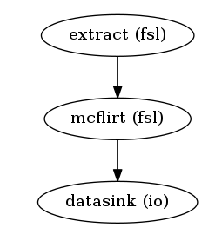

In [33]:
# writing out graph
moCor.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[4,4])
img=mpimg.imread(os.path.join(outDir,"moCor","graph_orig.png"))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

And running the workflow.

In [31]:
# running the workflow
moCor.run()

190722-16:52:36,22 nipype.workflow INFO:
	 Workflow moCor settings: ['check', 'execution', 'logging', 'monitoring']
190722-16:52:36,35 nipype.workflow INFO:
	 Running serially.
190722-16:52:36,37 nipype.workflow INFO:
	 [Node] Setting-up "moCor.extract" in "/tmp/Data/ds102/WorkflowOutput/moCor/extract".
190722-16:52:36,41 nipype.workflow INFO:
	 [Node] Cached "moCor.extract" - collecting precomputed outputs
190722-16:52:36,43 nipype.workflow INFO:
	 [Node] "moCor.extract" found cached.
190722-16:52:36,45 nipype.workflow INFO:
	 [Node] Setting-up "moCor.mcflirt" in "/tmp/Data/ds102/WorkflowOutput/moCor/mcflirt".
190722-16:52:36,49 nipype.workflow INFO:
	 [Node] Outdated cache found for "moCor.mcflirt".
190722-16:52:36,57 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /tmp/Data/ds102/WorkflowOutput/moCor/extract/sub-26_task-flanker_run-1_bold_roi.nii.gz -out /tmp/Data/ds102/WorkflowOutput/mo

# Examining motion correction results
<hr style="height:1px;border:none" />

## Plotting motion parameters
Now we can examine motion parameters saved on the output directories. First, we will examine shift and rotation parameters. As mentioned before, there are 3 parameters for shift and 3 parameters for rotation. These parameters are saved under **`par_file`** directory under **`Results`** datasink directory.

[`<PlotMoPar.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/MoCor/PlotMoPar.py)

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the data
resDir = '/tmp/Data/ds102/WorkflowOutput/Results/par_file'
resFname = 'sub-26_task-flanker_run-1_bold_roi_mcf.nii.gz.par'
moData = pd.read_csv(os.path.join(resDir,resFname),
                     header=None,
                     delimiter=r"\s+")

Here, the data file is read as a data frame named **`moData`**. The first 3 columns correspond to rotation, and the last 3 columns correspond to shifts.

In [38]:
moData.head()

,0,1,2,3,4,5
0,-0.006623,0.001209,-0.001220,-0.098383,-0.123247,-0.125800
1,-0.006945,0.001358,-0.001220,-0.098359,-0.123070,-0.125912
2,-0.006157,0.001299,-0.001220,-0.098371,-0.138439,-0.142253
3,-0.006643,0.001358,-0.001294,-0.098354,-0.128394,-0.087057
4,-0.006060,0.001306,-0.001220,-0.092145,-0.153513,-0.135497


Let's plot rotation first.

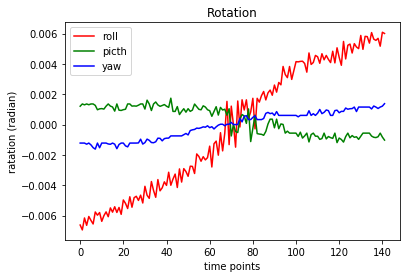

In [40]:
# plotting rotations
plt.plot(moData[0],'r', label='roll')
plt.plot(moData[1],'g', label='picth')
plt.plot(moData[2],'b', label='yaw')
plt.title('Rotation')
plt.xlabel('time points')
plt.ylabel('ratation (radian)')
plt.legend()
plt.show()

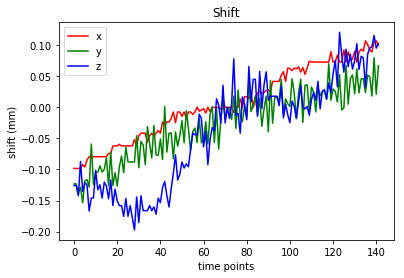

In [42]:
# plotting shifts
plt.plot(moData[3],'r', label='x')
plt.plot(moData[4],'g', label='y')
plt.plot(moData[5],'b', label='z')
plt.title('Shift')
plt.xlabel('time points')
plt.ylabel('shift (mm)')
plt.legend()
plt.show()

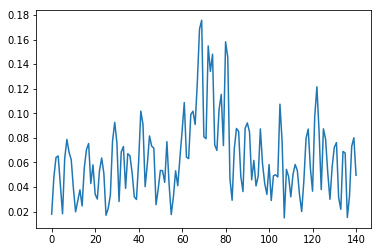

In [44]:
# loading the data
resDir = '/tmp/Data/ds102/WorkflowOutput/Results/rms_files'
resFname = 'sub-26_task-flanker_run-1_bold_roi_mcf.nii.gz_rel.rms'
moData = pd.read_csv(os.path.join(resDir,resFname),
                     header=None,
                     delimiter=r"\s+")

plt.plot(moData[0])
plt.show()

### Exercise
1. **Absolute displacement**: The output file with the suffix **`_abs.rms`** under **`rms_files`** directory contains the absolute displacement calculated at each time point as the squared sum of rotation and shift parameters. Plot the absolute displacement parameter over time.

2. **Relative displacement**: The output file with the suffix **`_rel.rms`** under **`rms_files`** directory contains the relative displacement calculated at each time point as the difference in absolute displacement from the previous time point. This is important information since a sudden movement (likely to induce artifacts) may be observed as a spike. Plot the relative displacement parameter over time, and identify any time points with spikes.

## Examining fMRI time series movie 

  * Movies of before and after motion correction by FSLeyes